In [2]:
import numpy as np
from scipy import integrate
from scipy.optimize import minimize_scalar as minisc
from scipy import interpolate
import matplotlib.pyplot as plt
import kidcalc

In [3]:
for Tc in [1.125]:    
    kbTc = Tc*86.17
    D0 = 1.76*kbTc
    N0 = 1.72e4
    kbTD = 37312.
    Vsc = kidcalc.Vsc(kbTc,N0,kbTD)

    def f(E,kbT):
        with np.errstate(over='raise',under='ignore'):
            try:
                return 1 / (1 + np.exp(E / kbT))
            except FloatingPointError:
                return np.exp(-E/kbT)

    def D(kbT,N0,Vsc,kbTD):
        def integrandD(E,D,kbT,N0,Vsc):
            return N0*Vsc*(1-2*f(E,kbT))/np.sqrt(E**2-D**2)

        def dint(D,kbT,N0,Vsc,kbTD):
            return np.abs(integrate.quad(integrandD,D,kbTD,
                                         args = (D,kbT,N0,Vsc))[0] - 1)
        res = minisc(dint, 
                     args = (kbT,N0,Vsc,kbTD),
                    method='brent',
                    options = {'xtol':1e-21})
        if res.success:
            return res.x

    points = 1000
    Ddata = np.zeros((3,points))
    i = 0
    for kbT in np.logspace(np.log10(0.01),np.log10(99e-2),points)*kbTc:
        Ddata[0,i] = kbT
        Ddata[1,i] = D(kbT,N0,Vsc,kbTD)
        Ddata[2,i] = kidcalc.nqp(kbT,Ddata[1,i],N0)
        i += 1
    np.save('Ddata_Al_{}'.format(str(Tc).replace('.','_')),Ddata)

In [4]:
Vsc

9.540116499452516e-06

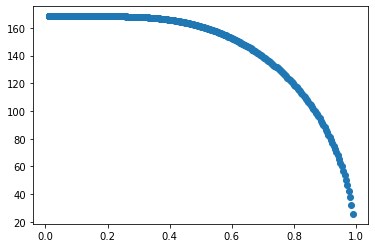

In [5]:
plt.plot(Ddata[0,:]/kbTc,Ddata[1,:],'o')
# Dspl = interpolate.splrep(Ddata[0, :], Ddata[1, :])
# plt.plot(np.linspace(0,1.2,points),
#          interpolate.splev(np.linspace(0,1.2,points)*86.17,Dspl))
# plt.xlim(0,.14)
# plt.ylim(181.9910399,181.9910401)
# plt.yscale('log')

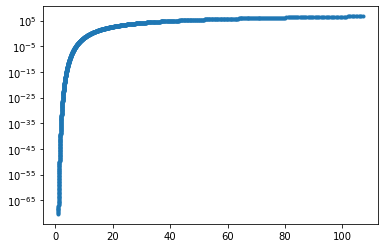

In [18]:
plt.plot(Ddata[0,:],Ddata[2,:], '.')
plt.yscale('log')